In [11]:
import os
import rasterio
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import datetime as dt
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy import stats, interpolate
from helper_functions import * # Helper functions
from scipy.stats import norm, gamma

In [4]:
dataset = '../../datasets/'
variables = xr.open_dataset(os.path.join(dataset, 'daily_dataset'), 
                            # chunks={'time': 500, 'y': 175, 'x': 148}
                           )

In [5]:
variables

<xarray.Dataset>
Dimensions:        (x: 591, y: 698, time: 7671)
Coordinates:
    band           int64 ...
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref    int64 ...
    lat            (y) float64 ...
    lon            (x) float64 ...
Data variables:
    precipitation  (time, y, x) float32 ...
    et             (time, y, x) float64 ...
    tws            (time, y, x) float64 ...
    landform       (y, x) float64 ...

In [7]:
precip = variables['precipitation']

# Resample to monthly sums
monthly_precip = precip.resample(time='1M').sum()

# Choose time scale, e.g., 3 months
time_scale = 3

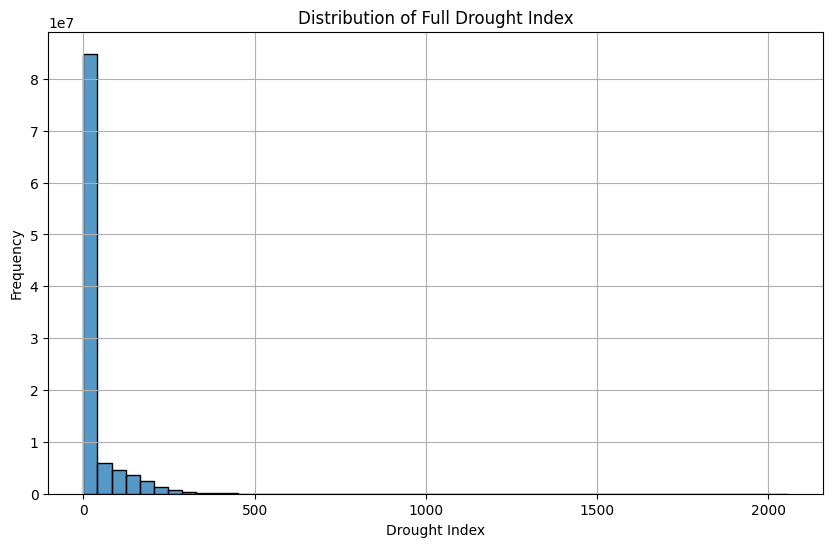

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(monthly_precip.values.flatten()[~np.isnan(monthly_precip.values.flatten())], bins=50)
plt.xlabel("Drought Index")
plt.ylabel("Frequency")
plt.title("Distribution of Full Drought Index")
plt.grid(True)
plt.show()

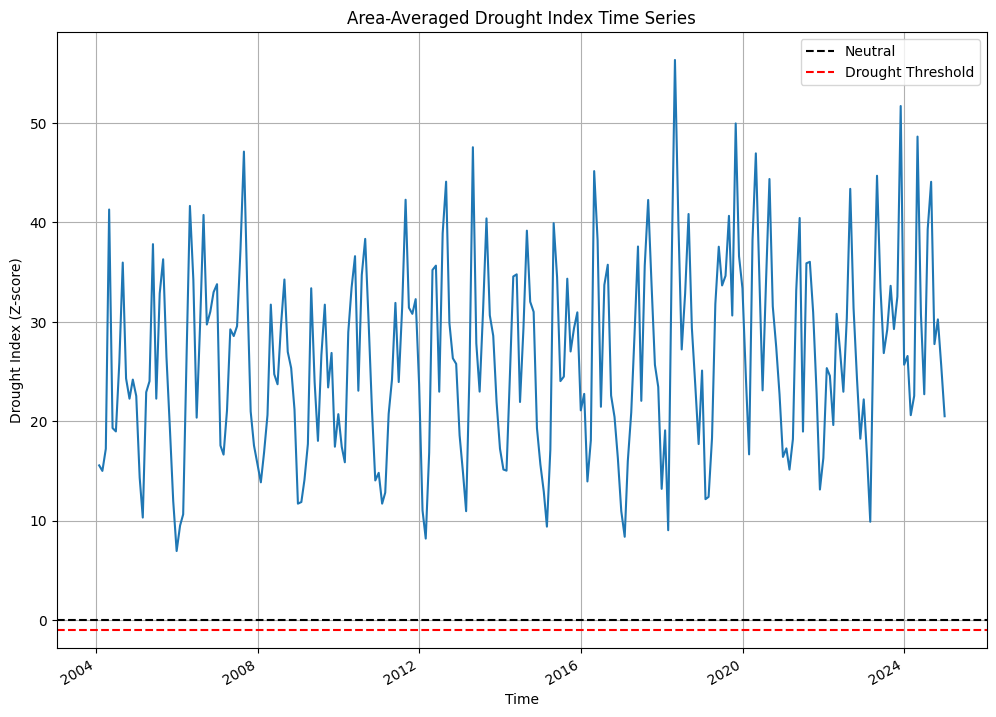

In [9]:
plt.figure(figsize=(12, 8))
monthly_precip.mean(dim=['y', 'x']).plot()
plt.axhline(0, color='k', linestyle='--', label='Neutral')
plt.axhline(-1, color='r', linestyle='--', label='Drought Threshold')
plt.xlabel("Time")
plt.ylabel("Drought Index (Z-score)")
plt.title("Area-Averaged Drought Index Time Series")
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


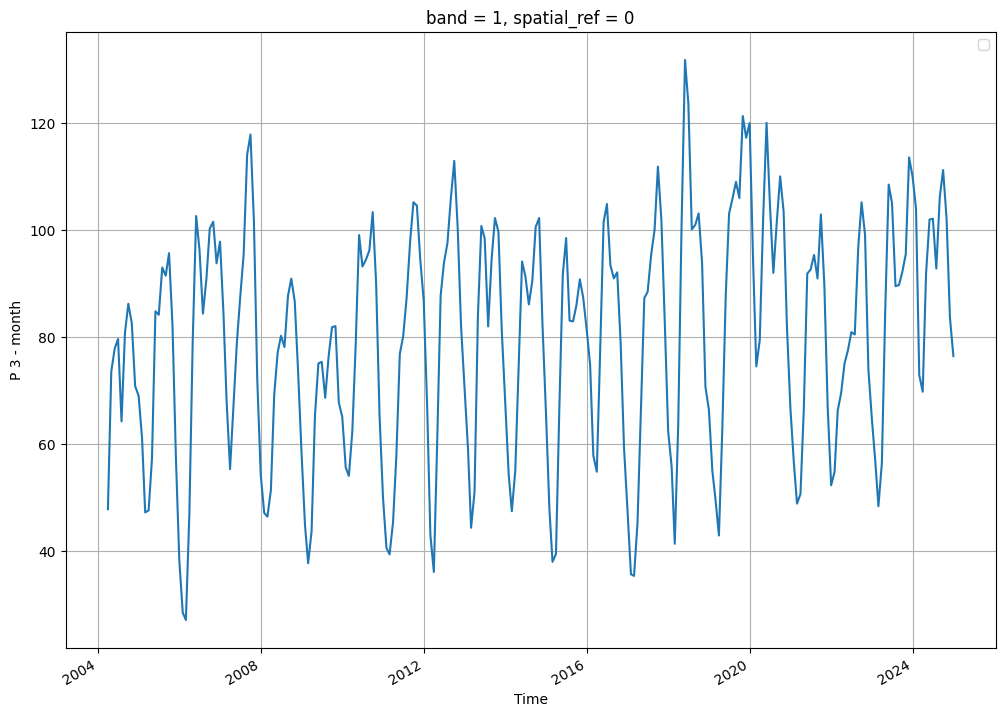

In [25]:
plt.figure(figsize=(12, 8))
accumulated_precip.mean(dim=['y', 'x']).plot()
plt.xlabel("Time")
plt.ylabel("P 3 - month")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Calculate accumulated precipitation over the time scale
accumulated_precip = monthly_precip.rolling(time=time_scale, min_periods=time_scale).sum()

# Fit gamma distribution to accumulated_precip
data = accumulated_precip.values.ravel()
data = data[~np.isnan(data)]  # Remove NaN values
shape, loc, scale = gamma.fit(data)


In [14]:
# Transform to standard normal distribution for SPI
cdf = gamma.cdf(data, shape, loc, scale)
spi = norm.ppf(cdf)

In [16]:
len(spi)

103129500

In [23]:
accumulated_precip

<xarray.DataArray 'precipitation' (time: 252, y: 698, x: 591)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
    band         int64 ...
  * x            (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
  * y            (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
    spatial_ref  int64 ...
    lat          (y) float64 ...
    lon          (x) float64 ...
  * time         (time) datetime64[ns] 2004-01-31 2004-02-29 ... 2024-12-31
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_DATETIME:          2015:09:01 17:11:33
    TIFFTAG_DOCUMENTNAME:      /home/sandbox/chirps/v2.0/daily_downscaled_by_...
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    TIFFTAG_SOFTWARE:          IDL 8.5, Exelis Visual Information Solutions, ...
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100
    units:                     mm
    grid_mapping:              spatial_ref

In [24]:
def calculate_spi(time_series):
    data = time_series.values
    data = data[~np.isnan(data)]
    if len(data) < 1:
        return np.full_like(time_series.values, np.NaN)
    shape, loc, scale = gamma.fit(data)
    cdf = gamma.cdf(time_series.values, shape, loc, scale)
    spi = norm.ppf(cdf)
    return spi

spi_dataset = accumulated_precip.groupby(['y','x']).apply(calculate_spi)

TypeError: `group` must be an xarray.DataArray or the name of an xarray variable or dimension. Received ['y', 'x'] instead.

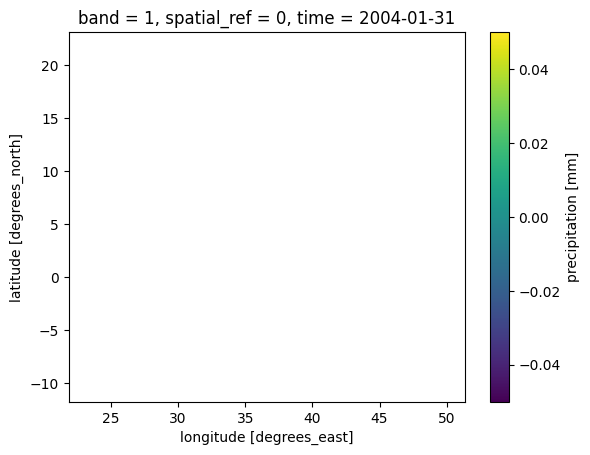

In [26]:
accumulated_precip.isel(time=0).plot()

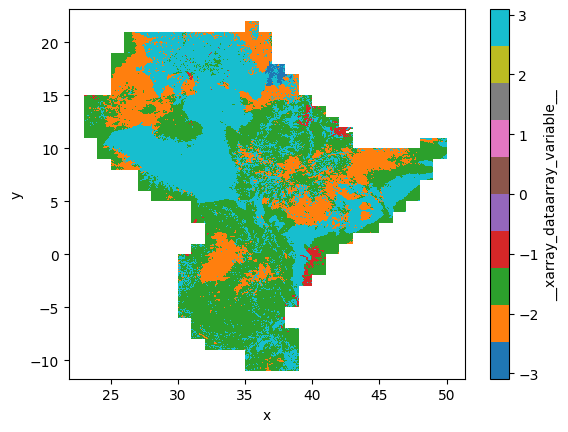

In [6]:
drought_2011 = ghadi.sel(time=slice("2011-01-01", "2011-12-31")).mean(dim="time")

drought_2011.plot(
    robust=True, cmap="tab10"
)

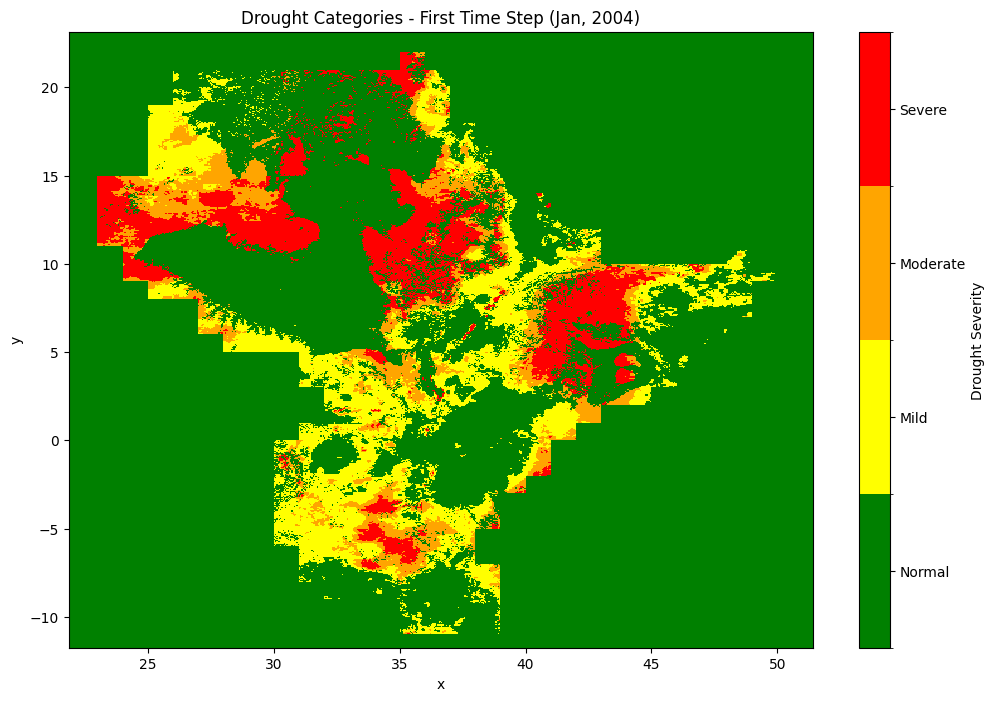

In [43]:

# Define and plot drought categories (Option 1)
drought_codes = xr.where(ghadi < -2, 3,
                         xr.where(ghadi < -1.5, 2,
                                  xr.where(ghadi < -1, 1, 0)))
# Create a custom colormap with white for NaN/background
from matplotlib.colors import ListedColormap
colors = ['green', 'yellow', 'orange', 'red']  # Normal, Mild, Moderate, Severe
cmap = ListedColormap(colors)
cmap.set_bad('white')  # Set NaN values to white

# Plot with white background
plt.figure(figsize=(12, 8), facecolor='white')  # Set figure background to white
ax = plt.gca()
ax.set_facecolor('white')  # Set axes background to white
drought_codes.isel(time=0).plot(cmap=cmap, levels=[0, 1, 2, 3, 4],
                                add_colorbar=True, cbar_kwargs={
                                    'ticks': [0.5, 1.5, 2.5, 3.5],
                                    'label': 'Drought Severity',
                                    'format': plt.FuncFormatter(lambda x, _: ['Normal', 'Mild', 'Moderate', 'Severe'][int(x-0.5)])
                                }, ax=ax)
plt.title("Drought Categories - First Time Step (Jan, 2004)")
plt.show()


In [42]:
drought_codes.isel(time=0)

<xarray.DataArray '__xarray_dataarray_variable__' (y: 698, x: 591)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
    time     datetime64[ns] 2004-01-15T12:00:00
  * y        (y) float64 -11.73 -11.68 -11.63 -11.58 ... 22.97 23.02 23.07 23.12
  * x        (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38

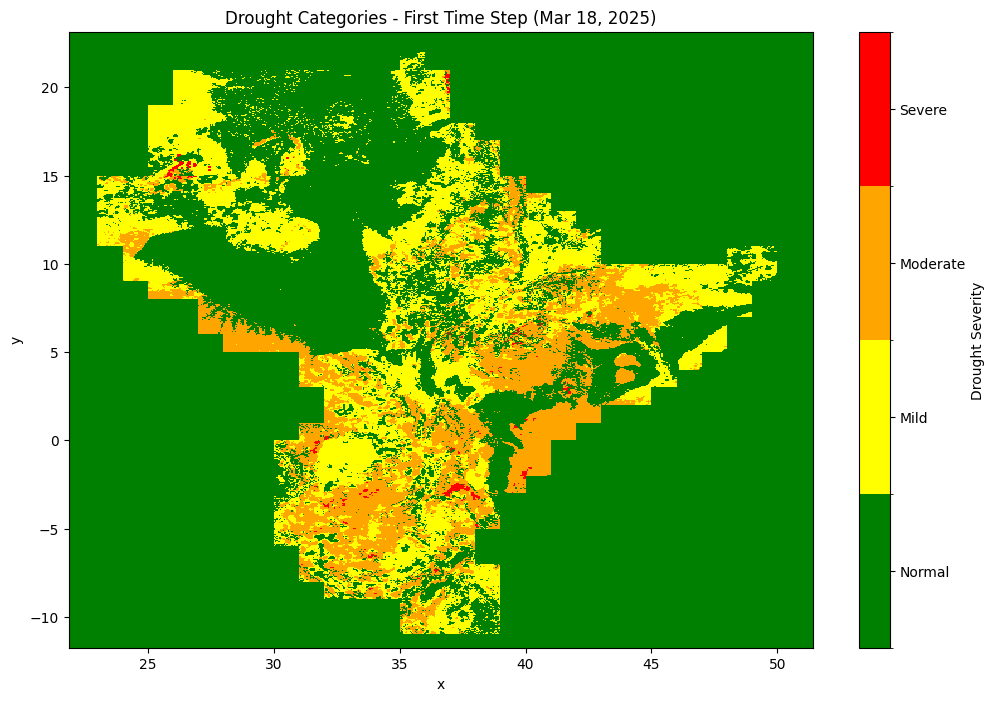

In [41]:
from matplotlib.colors import ListedColormap
colors = ['green', 'yellow', 'orange', 'red']  # Normal, Mild, Moderate, Severe
cmap = ListedColormap(colors)
cmap.set_bad('white')  # Set NaN values to white

plt.figure(figsize=(12, 8), facecolor='white')  # Set figure background to white
ax = plt.gca()
ax.set_facecolor('white')  # 
drought_codes.sel(time=slice("2022-01-01", "2022-12-31")).mean(dim="time").plot(cmap=cmap, levels=[0, 1, 2, 3, 4],
                                add_colorbar=True, cbar_kwargs={
                                    'ticks': [0.5, 1.5, 2.5, 3.5],
                                    'label': 'Drought Severity',
                                    'format': plt.FuncFormatter(lambda x, _: ['Normal', 'Mild', 'Moderate', 'Severe'][int(x-0.5)])
                                }, ax=ax)
plt.title("Drought Categories - First Time Step (Mar 18, 2025)")
plt.show()


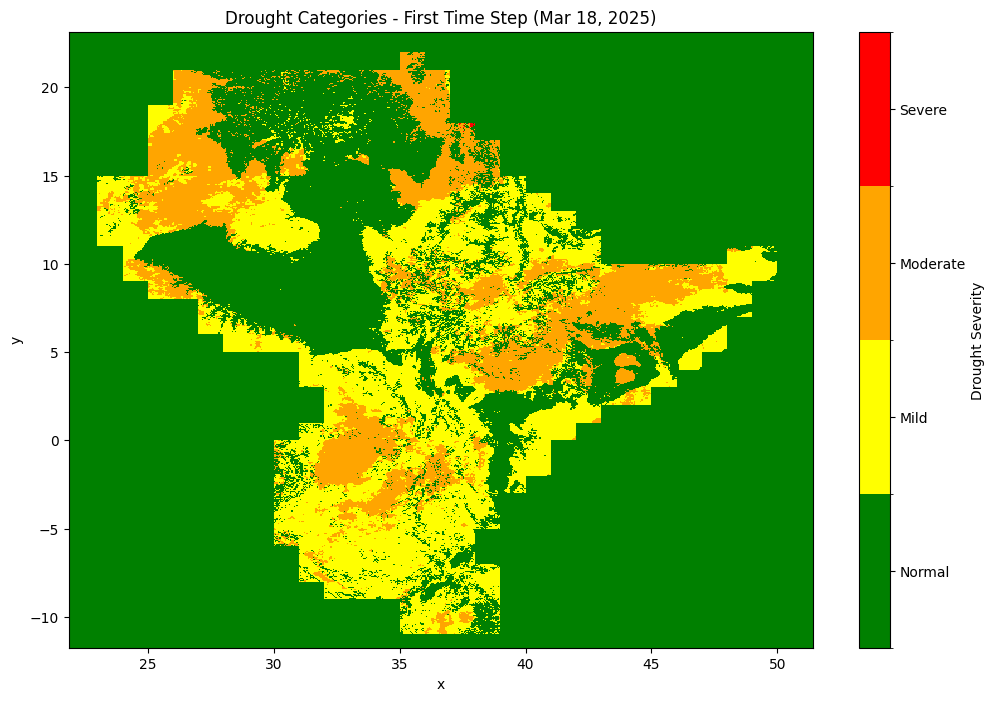

In [38]:
from matplotlib.colors import ListedColormap
colors = ['green', 'yellow', 'orange', 'red']  # Normal, Mild, Moderate, Severe
cmap = ListedColormap(colors)
cmap.set_bad('white')  # Set NaN values to white

plt.figure(figsize=(12, 8), facecolor='white')  # Set figure background to white
ax = plt.gca()
ax.set_facecolor('white')  # 
drought_codes.sel(time=slice("2011-01-01", "2011-12-31")).mean(dim="time").plot(cmap=cmap, levels=[0, 1, 2, 3, 4],
                                add_colorbar=True, cbar_kwargs={
                                    'ticks': [0.5, 1.5, 2.5, 3.5],
                                    'label': 'Drought Severity',
                                    'format': plt.FuncFormatter(lambda x, _: ['Normal', 'Mild', 'Moderate', 'Severe'][int(x-0.5)])
                                }, ax=ax)
plt.title("Drought Categories - First Time Step (Mar 18, 2025)")
plt.show()


In [31]:
# Span = timestep
def apply_ema(da, span=3):
    return da.rolling_exp(time=span, window_type="span").mean()

NameError: name 'first_subregion_id' is not defined

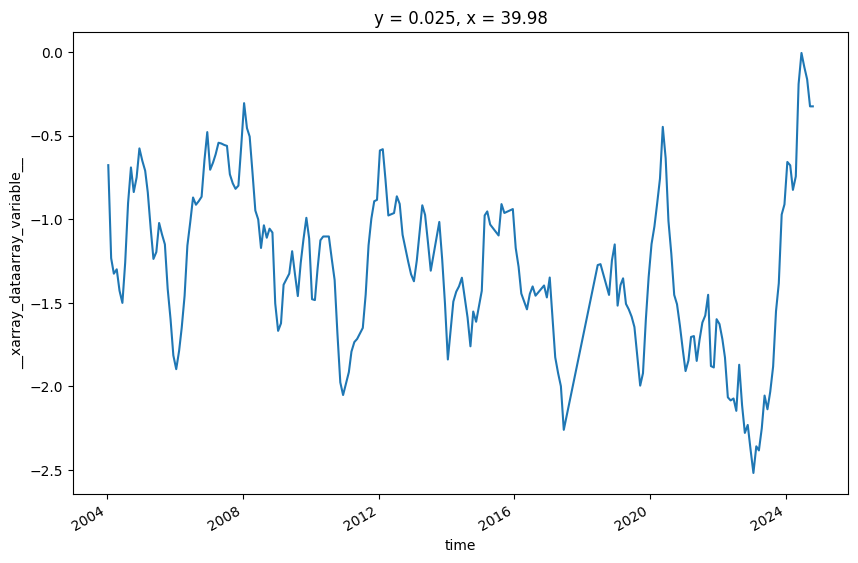

In [33]:
plt.figure(figsize=(10, 6))
# apply_ema(new_drought_index, span=6).sel(y=0, x=40, method="nearest").plot(label="GHDI")
apply_ema(ghadi, span=6).sel(y=0, x=40, method="nearest").plot(label="SPEI-03")
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.grid(True)
plt.show()

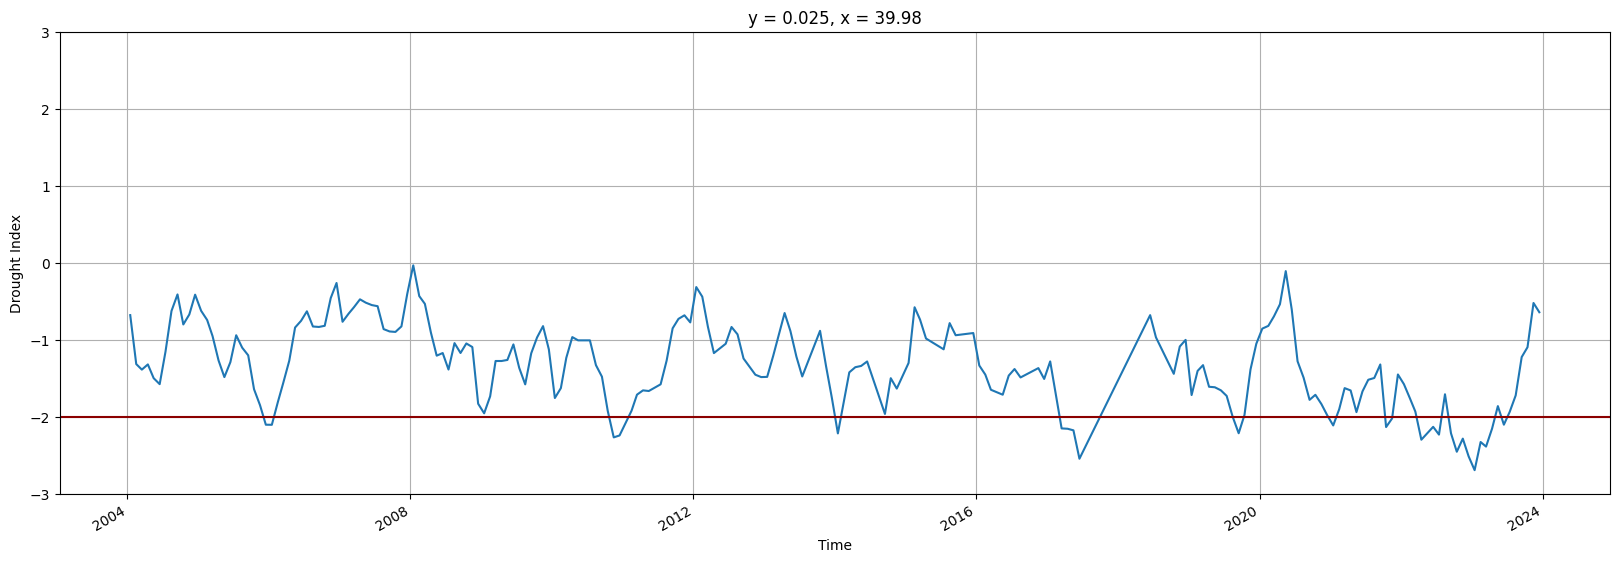

In [35]:
plt.figure(figsize=(20, 6))
apply_ema(ghadi.sel(time=slice('2004-01-01', '2023-12-31')), span=3).sel(y=0, x=40, method="nearest").plot(label="GHDI")
# spei03.sel(lat=5, lon=47.5, method="nearest").plot(label="SPEI-03")
# plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.axhline(y=-2, color='darkred')
plt.grid(True)
plt.show()

In [ ]:
# Continue with other analyses (e.g., time series, frequency)
plt.figure(figsize=(12, 8))
ghadi.mean(dim=['y', 'x']).plot()
plt.axhline(0, color='k', linestyle='--', label='Neutral')
plt.axhline(-1, color='r', linestyle='--', label='Drought Threshold')
plt.title("Area-Averaged Drought Index Time Series")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define drought categories
drought_categories = xr.where(ghadi < -2, 'Severe',
                              xr.where(ghadi < -1.5, 'Moderate',
                                       xr.where(ghadi < -1, 'Mild', 'Normal')))

# Map categories to numbers
category_map = {'Normal': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3}
drought_codes = drought_categories.map(category_map)

# Define a discrete colormap with white for NaN
colors = ['green', 'yellow', 'orange', 'red']
cmap = ListedColormap(colors)
cmap.set_bad('white')  # Set NaN values to white

# Plot with white background
plt.figure(figsize=(12, 8), facecolor='white')  # Figure background
ax = plt.gca()
ax.set_facecolor('white')  # Axes background
im = ax.pcolormesh(drought_codes.isel(time=0).x, drought_codes.isel(time=0).y, 
                   drought_codes.isel(time=0), cmap=cmap, vmin=0, vmax=3)
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(['Normal', 'Mild', 'Moderate', 'Severe'])
plt.title("Drought Categories - First Time Step (Mar 18, 2025)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

AttributeError: 'DataArray' object has no attribute 'map'